# Introduction to Computational Neuroscience

Stephen J Eglen  
2025-11-13

# Installation

This section sets up the packages required for this document. This takes
a few minutes to run, so we will start it and “leave it cooking”.

In [1]:
import Pkg
Pkg.add("Plots")
Pkg.add("OrdinaryDiffEq")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [2]:
using Plots
using OrdinaryDiffEq

# Introduction

-   “All models are wrong but some are useful” (Box, 1976?)
-   Introduction to modelling in computational neuroscience

# Background maths

## Euler integration

Given some differential equation for how x changes over time and so
initial condition (i.e. x = some value at time t = 0), we can integrate
them numerically using Euler integration.

$\frac{dx}{dt} = f(x,t)$

$x_{n+1} = x_{n}+ h \frac{dx}{dt}$

$x_{n+1} = x_{n}+ h f(x_{n}, nh)$

Depending on the step-size h.

## Trappenberg example (Appendix B)

Solve differential equation

$\frac{dx}{dt} = t -x + 1$

with initial conditions $x(0) = 1$.

Known solution:

$x(t) = \exp(-t) + t$

In [3]:
function euler1(h)
    tmax = 5.0;                               # max t value
    init = 1.0;                               # initial condition
    
    t = 0:h:tmax;                           # vector of time values
    nsteps = length(t);                     # how many steps
    x = zeros(nsteps,1);                    # where we will store
    # results
    x[1] = init;
    
    
    # Start the integration
    for i=1:(nsteps-1)
        f = t[i] - x[i] + 1;                # evaluate dx/dt
        x[i+1] = x[i] + (h*f);
    end
    ## why need space?
    hcat(t, x)
end

function plot_euler1(h)
    res = euler1(h);
    t = res[:,1]
    x = res[:,2]
    xtrue = @. exp(-t) + t;                    # true solution
    
    plot(t, hcat(x, xtrue), legend=:topleft,
         ylim=(0,5),
         xlim=(0,5),
         marker=:o,
         title = "Euler integration",
         xlabel="Time (s)", ylabel="x",
         label=["estimate" "true"])
end

plot_euler1 (generic function with 1 method)

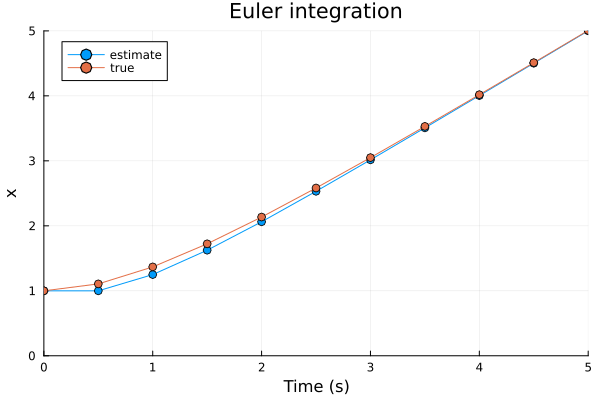

In [4]:
h_step = 0.5   # adjust between 0.01 and 1
plot_euler1(h_step)

# Hodgkin-Huxley model

## Reminder of the biology

Its all in the channels!

<http://tinyurl.com/matthews-channel>

## Reminder of the mathematics

See [hh_maths.pdf](hh_maths.pdf)

Julia has built-in functions for efficient numerical integration of
ODEs. We will use them here so that we focus on the problem and not the
numerics.

In [5]:
function hhode!(dy, y, p, t)
    v = y[1]; m = y[2]; n = y[3]; h = y[4];
    
    # Some constants of the system.
    I = p[1]
    gna = 1200; gk=360; gl=3;
    El=-54.387; Ek=-77.0; Ena=100.0;
    C = 10;
    
    
    am = 0.1*(v+40)/(1-exp(-(v+40)/10));
    bm = 4*exp(-(v+65)/18);
    
    ah = 0.07*exp(-(v+65)/20);
    bh = 1/(1+exp(-(v+35)/10));
    
    an = 0.01*(v+55)/(1-exp(-(v+55)/10));
    bn = 0.125*exp(-(v+65)/80);
    
    dv = (I - gna*h*(v-Ena)*m^3-gk*(v-Ek)*n^4-gl*(v-El))/C;
    
    dm = am*(1-m) -bm*m;
    dh = ah*(1-h) -bh*h;
    dn = an*(1-n) -bn*n;
    
    # Return derivatives
    dy[1]=dv;
    dy[2]=dm;
    dy[3]=dn;
    dy[4]=dh;
    
end


function plot_hh(;i=10)
    u0 = [-65.0;0.0529;0.3177;0.5961]
    tspan = (0.0,500.0)
    p = [i]
    prob = ODEProblem(hhode!,u0,tspan,p)
    
    sol = solve(prob,Vern7());
    
    
    l = @layout [a b; c d]
    p1 = plot(sol.t, sol[1,:], xlabel="t (ms)", ylabel= "V (mv)", 
              ylim=(-70,60), legend=false);
    p2 = plot(sol.t, sol[2,:], xlabel="t (ms)", ylabel= "m", 
              ylim=(0,1), legend=false);
    p3 = plot(sol.t, sol[3,:], xlabel="t (ms)", ylabel= "n", 
              ylim=(0,1), legend=false);
    p4 = plot(sol.t, sol[4,:], xlabel="t (ms)", ylabel= "h", 
              ylim=(0,1), legend=false);
    plot(p1, p2, p3, p4, layout = l)
end

plot_hh (generic function with 1 method)

Run with default I=0.1 and then compare with I=10.

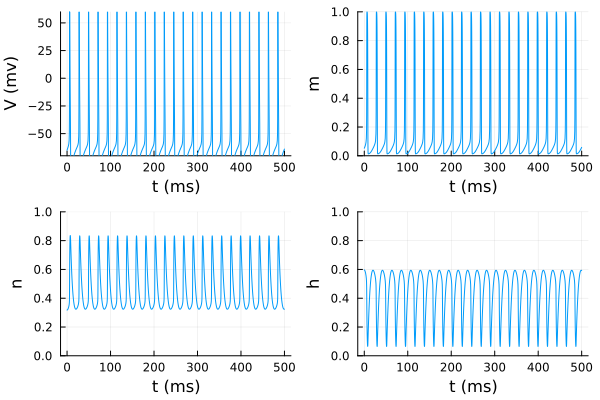

In [18]:
i_step = 9.3
plot_hh(i=i_step)

## Exercises

1.  Can you find the critical value of I where you first generate a
    spike?

2.  Can you work out the units on I (check equation 1 and Table 1 of
    hh_maths.pdf )?

3.  Estimate the firing rate (in Hz) for the model as you vary I from 0
    to 500. Can you plot a graph of it?

4.  (Advanced) Apply a pulse of negative current with I=-50 for 5 ms
    followed by I=0 and describe what happens.

5.  Try other manipulations, e.g. what if you set dh/dt to zero? What
    would this simulate?

# Izhikevich models

Let’s simplify the models as far as we can; we are going to use the
simplification due to Izhikevich.

Read [the basic
description](http://www.izhikevich.org/human_brain_simulation/Blue_Brain.htm#models%20of%20spiking%20neurons)
and guess which is the real data.

## The basic model

<figure>
<img src="http://www.izhikevich.org/publications/izhik.gif"
alt="the basic model" />
<figcaption aria-hidden="true">the basic model</figcaption>
</figure>

## Exercise: Izhikevich

1.  [izh.jl](izh.jl) has the basic code for one of the models. Try to
    adapt using parameters a,b,c,d to generate each of the plots from
    above. e.g. how can you make a chattering cell (CH)?

2.  Explore [figure1.jl](figure1.jl). This regenerates figure 1 of the
    [2004 paper](http://www.izhikevich.org/publications/whichmod.pdf).
    See if you can follow in the code how the model is adapted in each
    case.

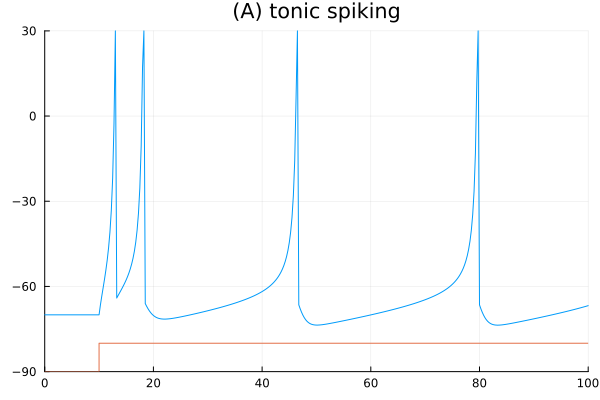

In [7]:
function izh(;a=0.02,b=0.2, c=-65.0, d=6.0)
    #a=0.02; b=0.2;  c=-65;  d=6;
    V=-70;  u=b*V;
    VV=[];  uu=[];
    tau = 0.25; tspan = 0:tau:100;
    T1=tspan[end]/10;
    for t=tspan
        if (t>T1)
            I=14;
        else
            I=0;
        end;
        V = V + tau*(0.04*V^2+5*V+140-u+I);
        u = u + tau*a*(b*V-u);
        if V > 30
            push!(VV,30);
            V = c;
            u = u + d;
        else
            push!(VV,V);
        end;
        push!(uu,u);
    end;
    plot(tspan,VV, title="(A) tonic spiking",
         legend=false,
         xlims=(0, tspan[end]), ylims=(-90,30));
    plot!([0,T1,T1,tspan[end]],-90.0 .+ [0,0,10,10])

end

izh(a=0.02, b=0.2, c=-65,  d=8)

## 20 cell types?

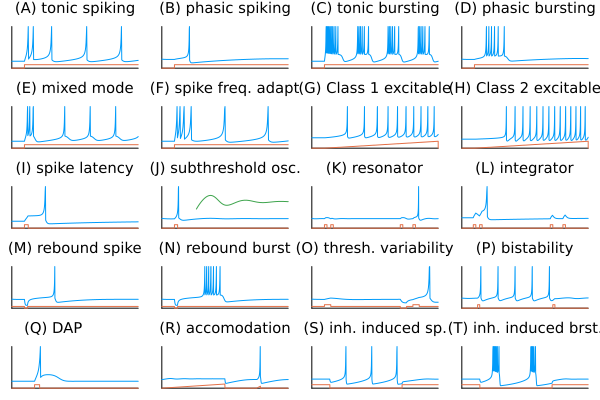

In [8]:
begin
    #   This file generates figure 1 in the paper by
    #               Izhikevich E.M. (2004)
    #   Which Model to Use For Cortical Spiking Neurons?
    
    #ENV["MPLBACKEND"]="qt4agg"
    
    using Statistics                # for the mean function
    
    #(A) tonic spiking
    
    function plot_ts(t,v,title)
        plot(t,v, title=title,
             titlefontsize=10,
             legend=false, axis=nothing,
             xlims=(0, t[end]), ylims=(-90,30));
    end
    
    function izh_a()
        a=0.02; b=0.2;  c=-65;  d=6;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:100;
        T1=tspan[end]/10;
        for t=tspan
            if (t>T1)
                I=14;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(A) tonic spiking")
        plot!([0,T1,T1,tspan[end]],-90.0 .+ [0,0,10,10])
    end
    
    function izh_b()
        # (B) phasic spiking
        a=0.02; b=0.25; c=-65;  d=6;
        V=-64; u=b*V;
        VV=[];  uu=[];
        tau = 0.25;tspan = 0:tau:200;
        T1=20;
        for t=tspan
            if (t>T1)
                I=0.5;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(B) phasic spiking")
        plot!([0,T1,T1,tspan[end]],-90.0 .+ [0,0,10,10])
    end
    
    
    #(C) tonic bursting
    function izh_c()
        a=0.02; b=0.2;  c=-50;  d=2;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:220;
        T1=22;
        for t=tspan
            if (t>T1)
                I=15;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(C) tonic bursting")
        plot!([0,T1,T1,tspan[end]],-90.0 .+[0,0,10,10])
    end
    
    #(D) phasic bursting
    function izh_d()
        a=0.02; b=0.25; c=-55;  d=0.05;
        V=-64;  u=b*V;
        VV=[];  uu=[];
        tau = 0.2;  tspan = 0:tau:200;
        T1=20;
        for t=tspan
            if (t>T1)
                I=0.6;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(D) phasic bursting")
        plot!([0,T1,T1,tspan[end]],-90.0 .+[0,0,10,10])
    end
    
    
    #(E) mixed mode
    function izh_e()
        a=0.02; b=0.2;  c=-55;  d=4;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:160;
        T1=tspan[end]/10;
        for t=tspan
            if (t>T1)
                I=10;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(E) mixed mode")
        plot!([0,T1,T1,tspan[end]],-90.0 .+[0,0,10,10])
    end
    
    #(F) spike freq. adapt
    function izh_f()
        a=0.01; b=0.2;  c=-65;  d=8;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:85;
        T1=tspan[end]/10;
        for t=tspan
            if (t>T1)
                I=30;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(F) spike freq. adapt")
        plot!([0,T1,T1,tspan[end]],-90.0 .+[0,0,10,10])
    end
    
    
    #(G) Class 1 exc.
    function izh_g()
        a=0.02; b=-0.1; c=-55; d=6;
        V=-60; u=b*V;
        VV=[]; uu=[];
        tau = 0.25; tspan = 0:tau:300;
        T1=30;
        for t=tspan
            if (t>T1)
                I=(0.075*(t-T1));
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+4.1*V+108-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(G) Class 1 excitable")
        plot!([0,T1,tspan[end],tspan[end]],-90.0 .+[0,0,20,0])
    end
    
    
    #(H) Class 2 exc.
    function izh_h()
        a=0.2;  b=0.26; c=-65;  d=0;
        V=-64;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:300;
        T1=30;
        for t=tspan
            if (t>T1)
                I=-0.5+(0.015*(t-T1));
            else
                I=-0.5;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(H) Class 2 excitable")
        plot!([0,T1,tspan[end],tspan[end]],-90.0 .+[0,0,20,0])
    end
    
    
    # (I) spike latency
    function izh_i()
        a=0.02; b=0.2;  c=-65;  d=6;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.2; tspan = 0:tau:100;
        T1=tspan[end]/10;
        for t=tspan
            if (t>T1) & (t < T1+3)
                I=7.04;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(I) spike latency")
        plot!([0,T1,T1,T1 + 3,T1+3,tspan[end]],-90.0 .+[0,0,10,10,0,0])
    end
    
    
    #(J) subthresh. osc.
    function izh_j()
        a=0.05; b=0.26; c=-60;  d=0;
        V=-62;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:200;
        T1=tspan[end]/10;
        for t=tspan
            if (t>T1) & (t < T1+5)
                I=2;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(J) subthreshold osc.")
        plot!([0,T1,T1,T1+5,T1+5,tspan[end]],-90.0 .+[0,0,10,10,0,0])
        plot!(tspan[220:end],-10 .+ 20*(VV[220:end] .- mean(VV)));
    end
    
    
    #(K) resonator
    function izh_k()
        a=0.1;  b=0.26; c=-60;  d=-1;
        V=-62;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:400;
        T1=tspan[end]/10;
        T2=T1+20;
        T3 = 0.7*tspan[end];
        T4 = T3+40;
        for t=tspan
            if ((t>T1) & (t < T1+4)) || ((t>T2) & (t < T2+4)) || ((t>T3) & (t < T3+4)) || ((t>T4) & (t < T4+4))
                I=0.65;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(K) resonator")
        plot!([0,T1,T1,(T1+8),(T1+8),T2,T2,(T2+8),(T2+8),T3,T3,(T3+8),(T3+8),T4,T4,(T4+8),(T4+8),tspan[end]],-90.0 .+[0,0,10,10,0,0,10,10,0,0,10,10,0,0,10,10,0,0]);
    end
    
    
    # (L) integrator
    function izh_l()
        a=0.02; b=-0.1; c=-55; d=6;
        V=-60; u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:100;
        T1=tspan[end]/11;
        T2=T1+5;
        T3 = 0.7*tspan[end];
        T4 = T3+10;
        for t=tspan
            if ((t>T1) & (t < T1+2)) | ((t>T2) & (t < T2+2)) | ((t>T3) & (t < T3+2)) | ((t>T4) & (t < T4+2))
                I=9;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+4.1*V+108-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(L) integrator")
        plot!([0,T1,T1,(T1+2),(T1+2),T2,T2,(T2+2),(T2+2),T3,T3,(T3+2),(T3+2),T4,T4,(T4+2),(T4+2),tspan[end]],-90.0 .+[0,0,10,10,0,0,10,10,0,0,10,10,0,0,10,10,0,0]);
    end
    
    
    #(M) rebound spike
    function izh_m()
        a=0.03; b=0.25; c=-60;  d=4;
        V=-64;  u=b*V;
        VV=[];  uu=[];
        tau = 0.2;  tspan = 0:tau:200;
        T1=20;
        for t=tspan
            if (t>T1) & (t < T1+5)
                I=-15;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(M) rebound spike")
        plot!([0,T1,T1,(T1+5),(T1+5),tspan[end]], -85.0 .+ [0,0,-5,-5,0,0]);
    end
    
    
    #(N) rebound burst
    function izh_n()
        a=0.03; b=0.25; c=-52;  d=0;
        V=-64;  u=b*V;
        VV=[];  uu=[];
        tau = 0.2;  tspan = 0:tau:200;
        T1=20;
        for t=tspan
            if (t>T1) & (t < T1+5)
                I=-15;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(N) rebound burst")
        plot!([0,T1,T1,(T1+5),(T1+5),tspan[end]],-85.0 .+ [0,0,-5,-5,0,0]);
    end
    
    
    #(O) thresh. variability
    function izh_o()
        a=0.03; b=0.25; c=-60;  d=4;
        V=-64;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:100;
        for t=tspan
            if ((t>10) & (t < 15)) | ((t>80) & (t < 85))
                I=1;
            elseif (t>70) & (t < 75)
                I=-6;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(O) thresh. variability")
        plot!([0,10,10,15,15,70,70,75,75,80,80,85,85,tspan[end]],
                -85.0 .+ [0,0,5,5,0,0,-5,-5,0,0,5,5,0,0]);
    end
    
    
    #(P) bistability
    function izh_p()
        a=0.1;  b=0.26; c=-60;  d=0;
        V=-61;  u=b*V;
        VV=[];  uu=[];
        tau = 0.25; tspan = 0:tau:300;
        T1=tspan[end]/8;
        T2 = 216;
        for t=tspan
            if ((t>T1) & (t < T1+5)) || ((t>T2) & (t < T2+5))
                I=1.24;
            else
                I=0.24;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV, "(P) bistability")
    
        plot!([0,T1,T1,(T1+5),(T1+5),T2,T2,(T2+5),(T2+5),tspan[end]],-90.0 .+[0,0,10,10,0,0,10,10,0,0]);
    end
    
    
    # (Q) DAP
    function izh_q()
        a=1;  b=0.2; c=-60;  d=-21;
        V=-70;  u=b*V;
        VV=[];  uu=[];
        tau = 0.1; tspan = 0:tau:50;
        T1 = 10;
        for t=tspan
            if abs(t-T1)<1
                I=20;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,         "(Q) DAP         ")
        plot!([0,T1-1,T1-1,T1+1,T1+1,tspan[end]],-90.0 .+[0,0,10,10,0,0]);
    end
    
    
    #(R) accomodation
    function izh_r()
        a=0.02;  b=1; c=-55;  d=4;
        V=-65;  u=-16;
        VV=[];  uu=[];  II=[];
        tau = 0.5; tspan = 0:tau:400;
        for t=tspan
            if (t < 200)
                I=t/25;
            elseif t < 300
                I=0;
            elseif t < 312.5
                I=(t-300)/12.5*4;
            else
                I=0;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*(V+65));
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
            push!(II,I);
        end;
        plot_ts(tspan,VV, "(R) accomodation")
        plot!(tspan,II*1.5 .- 90.0);
    end
    
    
    # (S) inhibition induced spiking
    function izh_s()
        a=-0.02;  b=-1; c=-60;  d=8;
        V=-63.8;  u=b*V;
        VV=[];  uu=[];
        tau = 0.5; tspan = 0:tau:350;
        for t=tspan
            if (t < 50) || (t>250)
                I=80;
            else
                I=75;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,  "(S) inh. induced sp.")
        plot!([0,50,50,250,250,tspan[end]], -80.0 .+ [0,0,-10,-10,0,0]);
    end
    
    
    # (T) inhibition induced bursting
    function izh_t()
        a=-0.026;  b=-1; c=-45;  d=-2;
        V=-63.8;  u=b*V;
        VV=[];  uu=[];
        tau = 0.5; tspan = 0:tau:350;
        for t=tspan
            if (t < 50) || (t>250)
                I=80;
            else
                I=75;
            end;
            V = V + tau*(0.04*V^2+5*V+140-u+I);
            u = u + tau*a*(b*V-u);
            if V > 30
                push!(VV,30);
                V = c;
                u = u + d;
            else
                push!(VV,V);
            end;
            push!(uu,u);
        end;
        plot_ts(tspan,VV,"(T) inh. induced brst.")
        plot!([0,50,50,250,250,tspan[end]],
                -80.0 .+ [0,0,-10,-10,0,0]);
    end
    
    
    p_a = izh_a();
    p_b = izh_b();
    p_c = izh_c();
    p_d = izh_d();
    
    p_e = izh_e()
    p_f = izh_f()
    p_g = izh_g()
    p_h = izh_h()
    
    p_i = izh_i()
    p_j = izh_j()
    p_k = izh_k()
    p_l = izh_l()
    
    p_m = izh_m()
    p_n = izh_n()
    p_o = izh_o()
    p_p = izh_p()
    
    p_q = izh_q()
    p_r = izh_r()
    p_s = izh_s()
    p_t = izh_t()
    
    
    l = @layout [a b c d; e f g h; i j k l; m n o p; q r s t]
    
    plot(p_a, p_b, p_c, p_d,
         p_e, p_f, p_g, p_h,
         p_i, p_j, p_k, p_l,
         p_m, p_n, p_o, p_p,
         p_q, p_r, p_s, p_t,
         layout = l)
    
    #set(gcf,'Units','normalized','Position',[0.3 0.1 0.6 0.8]);
    
end

# Coupling two neurons

## Winner-take-all (WTA) network.

Eqn 6.18 from Wilson (1999). Couple two neurons that inhibit each other.

$\tau \frac{dE_1}{dt} = -E_1 + S(K_1 - 3E_2)$

$\tau \frac{dE_2}{dt} = -E_2 + S(K_2 - 3E_1)$

$S(x) = [ 100(x^2) / (120^2 + x^2) ]_+$

We will first run WTA2 with input to neuron 1 = 60 and input to neuron 2
= 70. We will examine the phase plane.

In [9]:
function WTA2(k1, k2)
    Total_Equations = 2;  #Solve for this number of interacting Neurons
    DT = 2;  #Time increment as fraction of time constant
    Final_Time = 400;   #Final time value for calculation
    Last = (Int)(Final_Time/DT + 1);  #Last time step
    Time = DT*collect(0:Last-1);  #Time vector
    Tau = 20;  #Neural time constants in msec
    WTS = [1 2 2 1];  #Runge-Kutta Coefficient weights
    X = zeros(Total_Equations, Int(Last))
    K = zeros(Total_Equations, length(WTS))
    Weights = repeat(WTS, 2,1)
    X[1,1] = 1.0; X[2,1] = 0.0;
    Wt2 = [0 .5 .5 1];  #Second set of RK weights
    rkIndex = [1 1 2 3];
    K1= k1; K2=k2
    S(x) = x>0 ? 100x^2 / (120^2 +x^2) : 0
    K = zeros(2,length(rkIndex))
    for T = 2:Last
        for rk = 1:4  #Fourth Order Runge-Kutta
            XH = X[:, T-1] + K[:, rkIndex[rk]] *Wt2[rk];
            Tme = Time[T-1] + Wt2[rk]*DT;  #Time upgrade
            PSP1 = (K1 - 3*XH[2])*(XH[2] < K1/3);
            PSP2 = (K2 - 3*XH[1])*(XH[1] < K2/3);
            K[1, rk] = DT/Tau*(-XH[1] + S(PSP1))
            K[2, rk] = DT/Tau*(-XH[2] + S(PSP2))
        end
        newx = X[:, T-1] + sum((Weights.*K)',dims=1)'/6
        X[:, T] = newx
    end
    Time, X
end

WTA2 (generic function with 1 method)

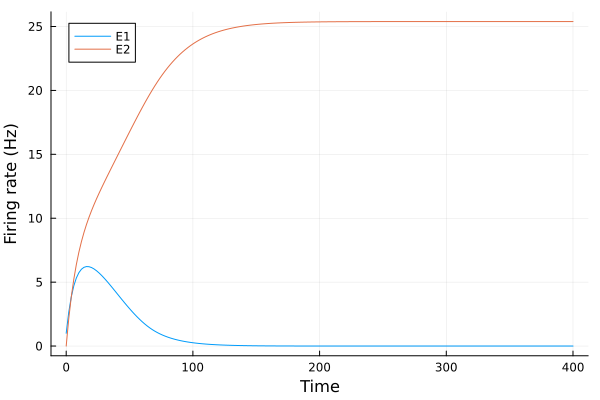

In [10]:
time, res = WTA2(60.0, 70.0)
plot(time, res', label=["E1" "E2"], xlabel = "Time", ylabel="Firing rate (Hz)")

### Exercises

1.  When the input to both cells is equal, what is the critical value
    when one neurons dominates? Start with input to both cells equal to
    20.

2.  Examine what happens when input to both neurons is 100. Run it
    several times and see which one wins. Can you explain (and then
    test) your result?

## Coupling inhibitory neurons, part II.

Wilson (Chapter 12) shows how pairs of neurons coupled with reciprocal
inhibition can generate out-of-phase firing (not WTA).

Try [IPSP.jl](IPSP.jl) with $I_1 = 1.1, I_2=1.0, k=5$. We should see
out-of-phase spiking.

### Exercises

1.  Set TauSyn to 2 ms (rather than 1 ms) and repeat with above
    parameters. What do you observe?

2.  As above, but with $I_1 = 1.05$; now what happens?

In [11]:
function IPSPinteractions(Stim1, Stim2, ES, TauSyn)
    ## e.g. 1, 2, 4, 1.27
    Total_Neurons = 8;  #Solve for this number of interacting Neurons
    DT = 0.02;  #Time increment as fraction of time constant
    Final_Time = 100;   #Final time value for calculation
    Last = Int64(Final_Time/DT + 1);  #Last time step
    Time = DT*(0:Last-1);  #Time vector
    Tau = 1.0;  #Neural time constants in msec
    TauR = 5.6
    WTS = [1 2 2 1];  #Runge-Kutta Coefficient weights

    # Predefine X, K and WTS for speed
    X = zeros(Total_Neurons, Last)
    K = zeros(Total_Neurons, 4)
    Weights = zeros(Total_Neurons, 4)
    
    for NU = 1:Total_Neurons;  #Initialize
        Weights[NU, :] = WTS;  #Make into matrix for efficiency in main loop
    end
    X[1, 1] = -0.754;  #Initial conditions here if different from zero
    X[2, 1] = 0.279;  #Initial conditions here if different from zero
    X[3, 1] = -0.754;  #Initial conditions here if different from zero
    X[4, 1] = 0.279;  #Initial conditions here if different from zero
    Wt2 = [0 .5 .5 1];  #Second set of RK weights
    rkIndex = [1 1 2 3]
    #Stim1 = 1#input("Stimulating current strength, neuron 1 (red) (0-2): ")
    #Stim2 = 2#input("Stimulating current strength, neuron 2 (blue) (0-2): ")
    #ES = 4#input("Inhibitory synaptic conductance factor (0-6): ")

    #**********
    #TauSyn = 1.27;  #IPSP time constant
    #**********

    SynThresh = -0.2;  #Threshold for IPSP conductance change

    ST = 10.6
    for T = 2:Last
      for rk = 1:4  #Fourth Order Runge-Kutta
        XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]
        Tme =Time[T-1] + Wt2[rk]*DT;  #Time upgrade

        K[1, rk] = DT/Tau*(-(17.81 + 47.58*XH[1] + 33.8*XH[1]^2)*(XH[1] - 0.48) - 26*XH[2]*(XH[1] + 0.95) + Stim1 - ES*XH[7]*(XH[1] + 0.92));  
        K[2, rk] = DT/TauR*(-XH[2] + 1.29*XH[1] + 0.79 + 3.3*(XH[1] + 0.38)^2)
        K[5, rk] = DT/TauSyn*(-XH[5] + (XH[3] > SynThresh))
        K[7, rk] = DT/TauSyn*(-XH[7] + XH[5])

        K[3, rk] = DT/Tau*(-(17.81 + 47.58*XH[3] + 33.8*XH[3]^2)*(XH[3] - 0.48) - 26*XH[4]*(XH[3] + 0.95)+ Stim2 - ES*XH[8]*(XH[3] + 0.92));  
        K[4, rk] = DT/TauR*(-XH[4]+ 1.29*XH[3] + 0.79 + 3.3*(XH[3] + 0.38)^2)
        K[6, rk] = DT/TauSyn*(-XH[6] + (XH[1] > SynThresh))
        K[8, rk] = DT/TauSyn*(-XH[8] + XH[6])

     end
        X[:, T] = X[:, T-1] + sum((Weights.*K)', dims=1)'/6
    end
    Time, X
end

IPSPinteractions (generic function with 1 method)

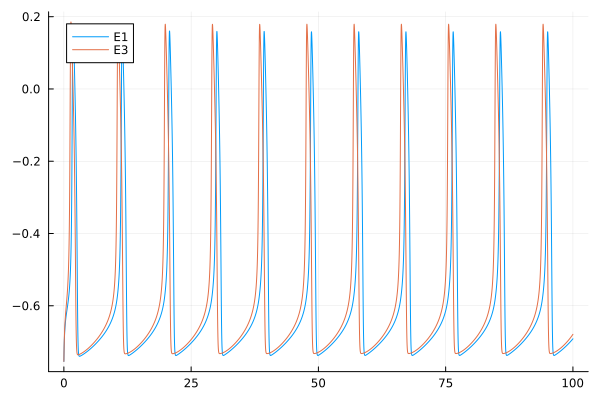

In [12]:
time1, X = IPSPinteractions(1.0, 1.1, 5.0, 2.0)
plot(time1, X[ [1, 3], :]', label=["E1" "E3"], legend=:topleft)